# Block Tokenizer + Embedding Visualizations

This notebook gives you a quick visual understanding of:
- how one schematic is converted into a graph,
- what a small local graph neighborhood looks like,
- and how node/block embeddings are arranged in 2D.

It uses your existing `blockgen` data pipeline and `VoxelPortGNN` model.

In [1]:
from pathlib import Path
from collections import Counter

import numpy as np
import torch
import matplotlib.pyplot as plt

from blockgen.utils.graph_data import (
    dataset_from_directory,
    EDGE_PORT_TO_PORT,
    NODE_BLOCK,
)
from blockgen.models.voxel_port_gnn import VoxelPortGNN
from blockgen.tokenizers.standard_vocab import STANDARD_VOCAB

plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams["axes.grid"] = True

PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "blockgen").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_DIR = PROJECT_ROOT / "data" / "raw"
print(f"Project root: {PROJECT_ROOT}")
print(f"Using data dir: {DATA_DIR}")

Project root: /home/griffing52/programming/gen/BlockGen
Using data dir: /home/griffing52/programming/gen/BlockGen/data/raw


/home/griffing52/programming/gen/BlockGen/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = dataset_from_directory(DATA_DIR, include_air=False, crop_non_air=True, max_dim=24)
graph = dataset[0]

print(f"Loaded sample: {graph.source_path}")
print(f"Total nodes: {graph.num_nodes:,}")
print(f"Total edges: {graph.edge_index.shape[1]:,}")
print(f"Block nodes: {(graph.node_type == NODE_BLOCK).sum().item():,}")
print(f"Port nodes: {(graph.node_type != NODE_BLOCK).sum().item():,}")

block_ids = graph.block_id[graph.node_type == NODE_BLOCK].cpu().numpy().tolist()
common = Counter(block_ids).most_common(12)
print("\nMost common block IDs in this sample:")
for block_id, count in common:
    name = STANDARD_VOCAB.get(str(int(block_id)), "Unknown")
    print(f"  id={block_id:>4}  count={count:>5}  {name}")

Loaded sample: /home/griffing52/programming/gen/BlockGen/data/raw/1.schematic
Total nodes: 4,802
Total edges: 10,682
Block nodes: 686
Port nodes: 4,116

Most common block IDs in this sample:
  id=   3  count=  291  Dirt(minecraft:dirt)
  id=   1  count=  281  Stone(minecraft:stone)
  id=   2  count=   83  Grass(minecraft:grass)
  id=  43  count=   13  Double Stone Slab(minecraft:double_stone_slab)
  id=   4  count=    8  Cobblestone(minecraft:cobblestone)
  id=  87  count=    4  Netherrack(minecraft:netherrack)
  id=  85  count=    3  Oak Fence(minecraft:fence)
  id=   5  count=    2  Oak Wood Plank(minecraft:planks)
  id=  67  count=    1  Cobblestone Stairs(minecraft:stone_stairs)


## 1) Visualize a small local graph neighborhood

This plot compresses the voxel graph into block-level connections (derived from port-to-port edges).
It gives a simple view of the structure topology the model is trying to learn.

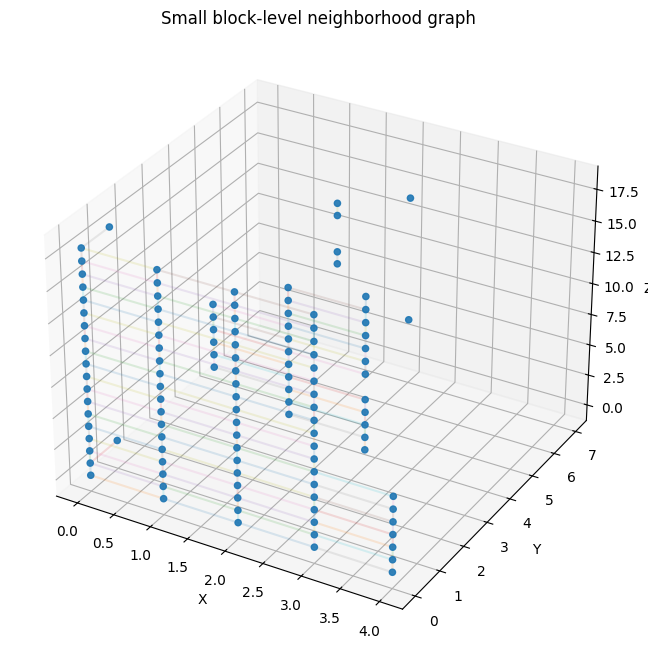

Plotted 120 block nodes and 187 block-to-block edges.


In [3]:
def vocab_name(block_id: int, block_data: int) -> str:
    key_with_data = f"{int(block_id)}:{int(block_data)}"
    if key_with_data in STANDARD_VOCAB:
        return STANDARD_VOCAB[key_with_data]
    return STANDARD_VOCAB.get(str(int(block_id)), f"Unknown({int(block_id)})")


def pca_2d(x: torch.Tensor) -> np.ndarray:
    x = x.float()
    x = x - x.mean(dim=0, keepdim=True)
    if x.shape[0] < 2:
        return np.zeros((x.shape[0], 2), dtype=np.float32)

    q = min(4, x.shape[0], x.shape[1])
    u, s, _ = torch.pca_lowrank(x, q=q)
    z = u[:, :2] * s[:2]

    if z.shape[1] < 2:
        z = torch.cat([z, torch.zeros((z.shape[0], 1), device=z.device)], dim=1)
    return z.detach().cpu().numpy()


port_edges = graph.edge_index[:, graph.edge_type == EDGE_PORT_TO_PORT]
parent = graph.parent_block
pos = graph.pos.float().cpu().numpy()

src_parent = parent[port_edges[0]]
dst_parent = parent[port_edges[1]]
valid = (src_parent >= 0) & (dst_parent >= 0)
src_parent = src_parent[valid].cpu().numpy()
dst_parent = dst_parent[valid].cpu().numpy()

pairs = set()
for a, b in zip(src_parent.tolist(), dst_parent.tolist()):
    if a == b:
        continue
    pairs.add(tuple(sorted((int(a), int(b)))))

pairs = sorted(list(pairs))
max_nodes_to_plot = 120
block_nodes = graph.block_node_index[:max_nodes_to_plot].cpu().numpy().tolist()
block_node_set = set(block_nodes)
filtered_pairs = [(a, b) for a, b in pairs if a in block_node_set and b in block_node_set]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

coords = pos[block_nodes]
ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], s=20, alpha=0.9)

for a, b in filtered_pairs[:300]:
    pa = pos[a]
    pb = pos[b]
    ax.plot([pa[0], pb[0]], [pa[1], pb[1]], [pa[2], pb[2]], alpha=0.15)

ax.set_title("Small block-level neighborhood graph")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

print(f"Plotted {len(block_nodes)} block nodes and {min(len(filtered_pairs), 300)} block-to-block edges.")

## 2) Visualize contextual node embeddings (from one forward pass)

These are **node latents** after message passing in `VoxelPortGNN`.
Without training, this is mostly structural initialization; after training, clusters should become more meaningful.

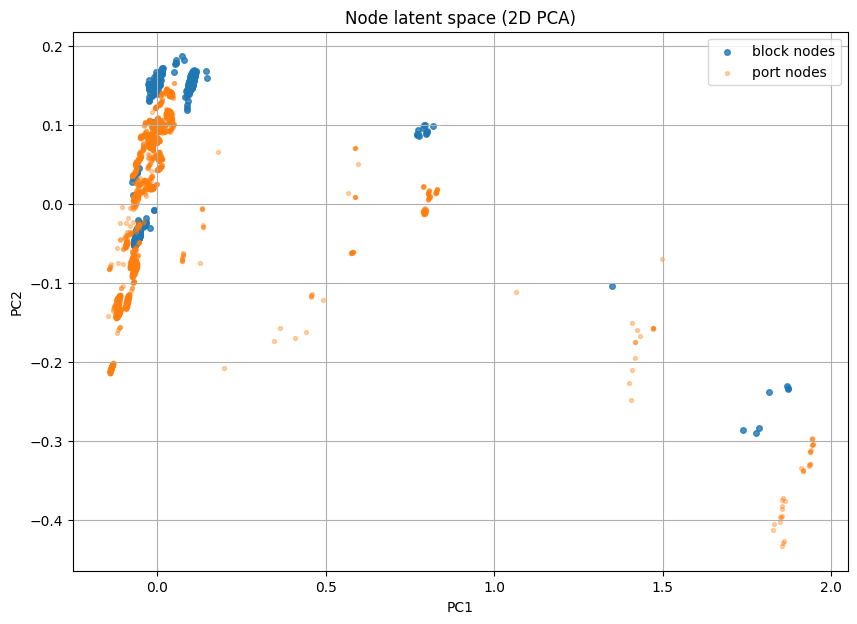

Latent shape: (4802, 64)
Block logits shape: (686, 4096)
Port-edge logits shape: (2450,)


In [4]:
model = VoxelPortGNN(hidden_dim=64, num_layers=2)
model.eval()

with torch.no_grad():
    out = model(graph)

latent = out["latent"].detach().cpu()
node_type = graph.node_type.detach().cpu().numpy()
points = pca_2d(latent)

plt.figure(figsize=(10, 7))
plt.scatter(points[node_type == 0, 0], points[node_type == 0, 1], s=16, alpha=0.8, label="block nodes")
plt.scatter(points[node_type == 1, 0], points[node_type == 1, 1], s=8, alpha=0.35, label="port nodes")
plt.title("Node latent space (2D PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

print("Latent shape:", tuple(latent.shape))
print("Block logits shape:", tuple(out["block_logits"].shape))
print("Port-edge logits shape:", tuple(out["port_edge_logits"].shape))

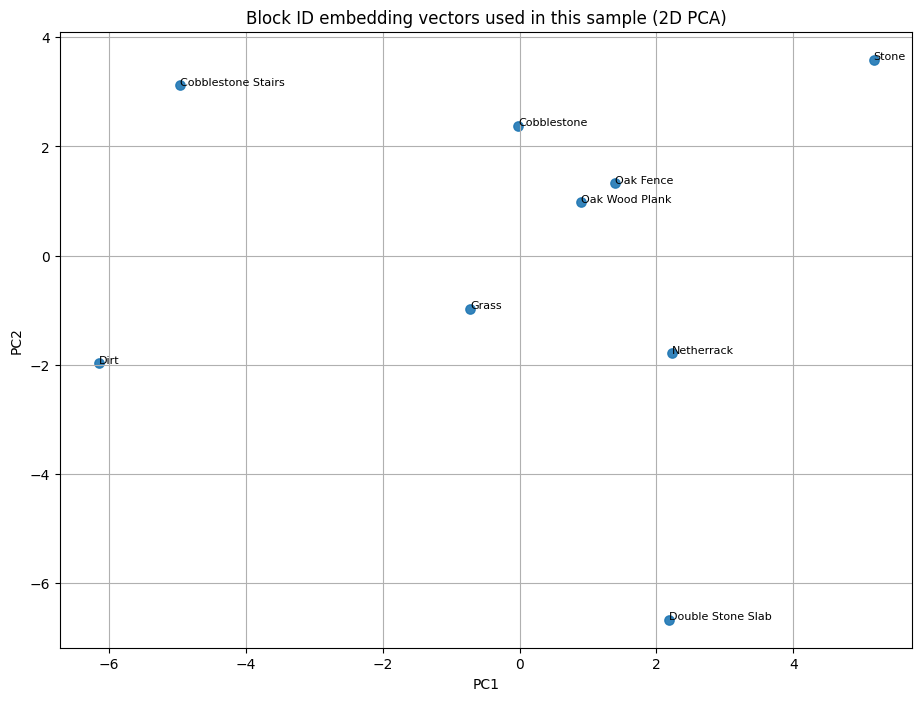

Unique block IDs in sample: 9
Unique mapped embedding IDs: 9


In [5]:
block_mask = graph.node_type == NODE_BLOCK
sample_block_ids = graph.block_id[block_mask].detach().cpu().numpy()
sample_block_data = graph.block_data[block_mask].detach().cpu().numpy()

num_embed = model.block_id_embedding.num_embeddings
mapped_ids = np.array([int(bid) % num_embed for bid in sample_block_ids], dtype=np.int64)
unique_mapped = np.unique(mapped_ids)

embed_table = model.block_id_embedding.weight.detach().cpu()
subset = embed_table[torch.as_tensor(unique_mapped, dtype=torch.long)]
subset_points = pca_2d(subset)

# representative labels from the sample
label_by_mapped = {}
for bid, bdata, mid in zip(sample_block_ids.tolist(), sample_block_data.tolist(), mapped_ids.tolist()):
    if mid not in label_by_mapped:
        label_by_mapped[mid] = vocab_name(int(bid), int(bdata))

plt.figure(figsize=(11, 8))
plt.scatter(subset_points[:, 0], subset_points[:, 1], s=45, alpha=0.9)

for i, mid in enumerate(unique_mapped[:20]):
    label = label_by_mapped.get(int(mid), f"id_mod_{int(mid)}")
    plt.annotate(label.split("(")[0][:28], (subset_points[i, 0], subset_points[i, 1]), fontsize=8)

plt.title("Block ID embedding vectors used in this sample (2D PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

print(f"Unique block IDs in sample: {len(np.unique(sample_block_ids))}")
print(f"Unique mapped embedding IDs: {len(unique_mapped)}")

## Next quick experiments

- Change `graph = dataset[k]` to compare structures.
- Increase/decrease `max_dim` to change graph size and detail.
- Swap in a trained checkpoint and re-run embedding plots to inspect learned clustering.
- Color the latent scatter by block ID for a stronger semantic view after training.